In [1]:
%matplotlib inline
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
import random

Loading the Images
------------------

### crop

In [25]:
image = Image.open("./data/kent_big.jpg")

w, h = image.size
print(image.size)

(700, 540)


In [26]:
image.crop((0, 0, 540, h)).save("./data/kent.jpg")

### del alpha size

In [81]:
import numpy

numpy_content_img = numpy.array(content_img)
content_img = image_loader("./data/MyPhoto1.png")

content_img = torch.FloatTensor(numpy.delete(numpy_content_img, 3, 1))

### load

In [82]:
imsize = 256 

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()]) 


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return torch.FloatTensor(image)


style_img = image_loader("./data/picasso.jpg")
#content_img = image_loader("./data/MyPhoto1.png")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

### Show the picts

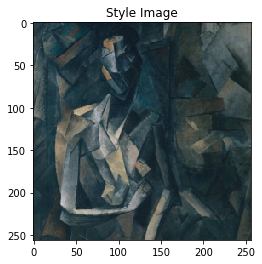

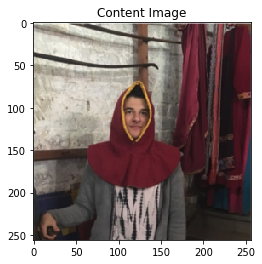

In [67]:
unloader = transforms.ToPILImage() 

def imshow(tensor, title=None):
    image = tensor.clone()  
    image = image.squeeze(0) # убираем размер батча
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Loss Functions
--------------

In [54]:
# gram mtrx
def gram_matrix(input):
    a, b, c, d = input.size()  
    features = input.view(a * b, c * d)  # reshape

    G = torch.mm(features, features.t())  # gramm 
    # normalize
    return G.div(a * b * c * d)

In [55]:
class ContentLoss(nn.Module):

    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [56]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

Import Model
-------------------

In [57]:
cnn = models.vgg19(pretrained=True).features.eval()

In [58]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

## add losses to model and crop


In [53]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace)
  (18): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [59]:
style_layers = [0, 2, 5, 7, 10]


normalization = Normalization(cnn_normalization_mean, cnn_normalization_std)
model = nn.Sequential()

model.add_module('-1', normalization)
content_losses = []
style_losses = []

i = 0  
for layer in cnn.children():
    print(layer)
    if isinstance(layer, nn.ReLU):
        layer = nn.ReLU(inplace=False)
    
    model.add_module(str(i), layer)
    
    if i == 7:
        target_feature = model(content_img).detach()
        content_loss = ContentLoss(target_feature)
        model.add_module('content_loss {}'.format(i), content_loss)
        content_losses.append(content_loss)
        
    if i in style_layers:
        target_feature = model(style_img).detach()
        style_loss = StyleLoss(target_feature)
        model.add_module('style_loss {}'.format(i), style_loss)
        style_losses.append(style_loss)
        
    if i == 10:
        break
    
    i += 1

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [60]:
model

Sequential(
  (-1): Normalization()
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 0): StyleLoss()
  (1): ReLU()
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 2): StyleLoss()
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 5): StyleLoss()
  (6): ReLU()
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss 7): ContentLoss()
  (style_loss 7): StyleLoss()
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss 10): StyleLoss()
)

Next, we select the input image. You can use a copy of the content image
or white noise.




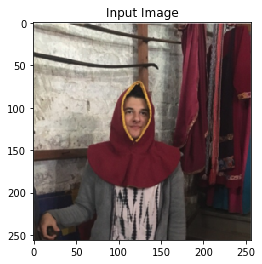

In [83]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

## Run the algorithm

In [87]:
num_steps = 300
style_weight = 1000000

optimizer = optim.LBFGS([input_img.requires_grad_()])

for i in range(1, num_steps + 1):
    
    print(i)
    def closure():
        input_img.data.clamp_(0, 1) 
        
        optimizer.zero_grad()
        model(input_img)
        style_score = 0 
        content_score = 0

        # Прибавляем лосс
        for sl in style_losses:
            style_score += sl.loss
        for cl in content_losses:
            content_score += cl.loss

        style_score *= style_weight
        
        if i % 1 == 0:
            print('i : {}, Style Loss : {:4f} Content Loss: {:4f}'.format(
                i, style_score.item(), content_score.item()))        
        
        loss = style_score + content_score
        loss.backward()
       
        return style_score + content_score
      


    optimizer.step(closure)

input_img.data.clamp_(0, 1)

1


NameError: name 'style_score' is not defined

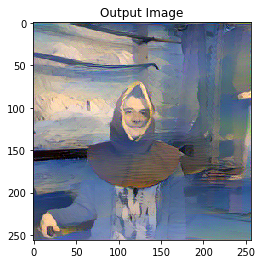

In [77]:
plt.figure()
imshow(input_img, title='Output Image')
plt.show()